In [1]:

pip install tensorflow_text

  Obtaining dependency information for tensorflow_text from https://files.pythonhosted.org/packages/88/a2/8d2ee50c8e5e355bf23975a0b7fa49ddd9c9b0ecb48b8c77d78ff4b3bcc0/tensorflow_text-2.10.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-hub>=0.8.0 from https://files.pythonhosted.org/packages/e5/50/00dba77925bf2a0a1e45d7bcf8a69a1d2534fb4bb277d9010bd148d2235e/tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow<2.11,>=2.10.0 from https://files.pythonhosted.org/packages/ad/87/f484e0b86687c97d2dfb081e03e948b796561fc8608b409a9366e3b4a663/tensorflow-2.10.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for protobuf<3.20,>=3.9.2 from https://files.pythonhosted.org/packages/97/f9/a14bac5331f3e55bcbbed906a0c8b112f554152ddf09efeb6f5f95653ffd/protobuf-3.19.6-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for tensorboard<2.11,>=2.10 from https://files.pythonhosted.or

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mysql-connector-python 8.1.0 requires protobuf<=4.21.12,>=4.21.1, but you have protobuf 3.19.6 which is incompatible.
streamlit 1.27.2 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.17.0 requires keras>=3.2.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import sklearn.preprocessing
import json
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
df = pd.read_csv('Symptom2Disease.csv')
df.drop('Unnamed: 0', axis='columns', inplace=True)
df['label'] = df['label'].apply(lambda x: x.title())
df.head(2)

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."


In [6]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
df = df.join(pd.DataFrame(label_binarizer.fit_transform(df['label']),
                         columns=label_binarizer.classes_,
                         index=df.index
                         ))
df.drop('label', axis='columns', inplace=True)
df.head(2)

,text,Acne,Allergy,Arthritis,Bronchial Asthma,Cervical Spondylosis,Chicken Pox,Common Cold,Dengue,Diabetes,...,Impetigo,Jaundice,Malaria,Migraine,Peptic Ulcer Disease,Pneumonia,Psoriasis,Typhoid,Urinary Tract Infection,Varicose Veins
0,I have been experiencing a skin rash on my arm...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"My skin has been peeling, especially on my kne...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
val_df = df.sample(frac=0.2)
train_df = df.drop(val_df.index)

print(f'Training Dataset Size: {len(train_df)}', f'Validation Dataset Size: {len(val_df)}', sep='\n')


Training Dataset Size: 960
Validation Dataset Size: 240


In [8]:
def dataframe_to_tf_dataset(dataframe):
    dataframe = dataframe.copy()
    feature = dataframe.pop('text')
    ds = tf.data.Dataset.from_tensor_slices((feature, dataframe))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [9]:
train_ds = dataframe_to_tf_dataset(train_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_ds = dataframe_to_tf_dataset(val_df).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [10]:
# Define input layer
text_input = tf.keras.Input(shape=(), name='text', dtype='string')

# Define preprocessing layer
preprocessor = hub.KerasLayer(
    'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3',
    name='bert_preprocessor'
)

# Process input through preprocessing layer
encoder_inputs = preprocessor(text_input)

# Define BERT encoder layer
encoder = hub.KerasLayer(
    'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-6-h-128-a-2/versions/2',
    trainable=True,
    name='bert_encoder'
)

# Pass processed input through encoder
outputs = encoder(encoder_inputs)

# Get the pooled output from the encoder
pooled_output = outputs['pooled_output']

# Apply dropout layer
x = tf.keras.layers.Dropout(0.20, name='dropout')(pooled_output)

# Define dense output layer with softmax activation function
outputs = tf.keras.layers.Dense(24, activation='softmax', name='output')(x)

In [11]:
model = tf.keras.Model(text_input, outputs, name='medaid')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "medaid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 bert_preprocessor (KerasLayer)  {'input_word_ids':   0          ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                     

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
15/15 [==============================] - 54s 2s/step - loss: 3.4646 - accuracy: 0.0500 - val_loss: 3.1773 - val_accuracy: 0.0750
Epoch 2/15
15/15 [==============================] - 33s 2s/step - loss: 2.8355 - accuracy: 0.1823 - val_loss: 2.0745 - val_accuracy: 0.4583
Epoch 3/15
15/15 [==============================] - 33s 2s/step - loss: 1.7008 - accuracy: 0.5500 - val_loss: 1.1056 - val_accuracy: 0.7708
Epoch 4/15
15/15 [==============================] - 34s 2s/step - loss: 0.8704 - accuracy: 0.7948 - val_loss: 0.6003 - val_accuracy: 0.8458
Epoch 5/15
15/15 [==============================] - 33s 2s/step - loss: 0.3841 - accuracy: 0.9438 - val_loss: 0.4653 - val_accuracy: 0.8583
Epoch 6/15
15/15 [==============================] - 33s 2s/step - loss: 0.2096 - accuracy: 0.9667 - val_loss: 0.3488 - val_accuracy: 0.8958
Epoch 7/15
15/15 [==============================] - 34s 2s/step - loss: 0.1067 - accuracy: 0.9865 - val_loss: 0.2542 - val_accuracy: 0.9375
Epoch 8/15
15/15 [==

In [15]:
model.save('model1.keras')

In [17]:
def predict(text):
#     print(f"Predicting for text: {text}")  # Debugging statement
    feature = {'text': text}
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in feature.items()}
    predictions = model.predict(input_dict, verbose=0)[0]
    classes = label_binarizer.classes_
    predictions_dict = {}

    for i in range(len(classes)):
        predictions_dict[classes[i]] = predictions[i] * 100
    
    # Check if predictions_dict is not empty
    if not predictions_dict:
        print("Warning: predictions_dict is empty!")
        return None
    
    # Sort predictions_dict and return
    predictions_dict = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1], reverse=True)}
    return predictions_dict


# predict("hii")


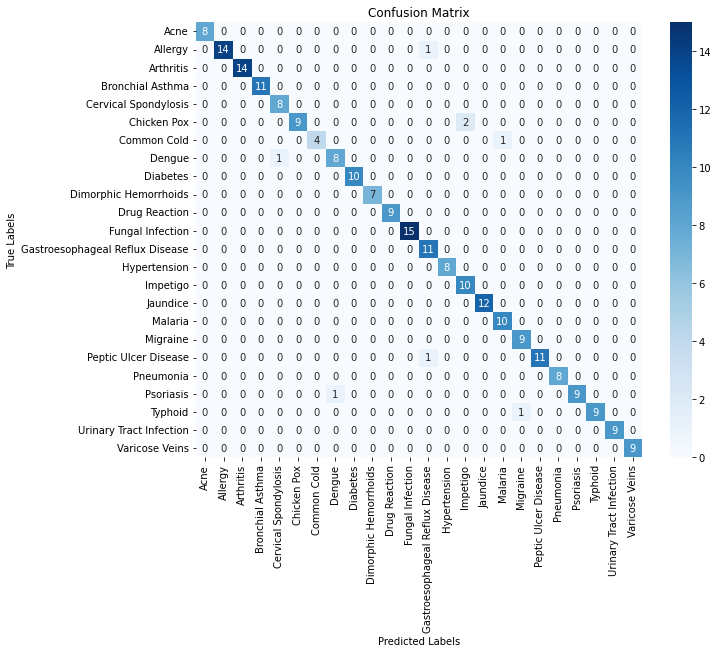

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the true labels from val_df (converting one-hot encoding to class indices)
true_labels = np.argmax(val_df.iloc[:, 1:], axis=1)

# Extract the text inputs for predictions
text_inputs = val_df.iloc[:, 0].values

# Initialize an empty list to hold the predicted labels
predicted_labels = []

# Loop through the text inputs to get predictions
for text in text_inputs:
    # Get the predictions for the given text
    predictions_dict = predict(text)
    
    if predictions_dict:
        # Get the class with the highest probability
        predicted_class = max(predictions_dict, key=predictions_dict.get)
        # Convert class name to index
        predicted_label_index = list(label_binarizer.classes_).index(predicted_class)
        predicted_labels.append(predicted_label_index)
    else:
        # Handle case where predictions_dict is None
        predicted_labels.append(None)

# Convert predicted_labels list to a numpy array
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.9667
Precision (weighted): 0.9706
Recall (weighted): 0.9667
F1-score (weighted): 0.9667

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.93      0.97        15
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        11
           4       0.89      1.00      0.94         8
           5       1.00      0.82      0.90        11
           6       1.00      0.80      0.89         5
           7       0.89      0.89      0.89         9
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        15
          12       0.85      1.00      0.92        11
          13       1.00      1.00      1.00         8
          14       0.83      1.00      0.91        10
          1

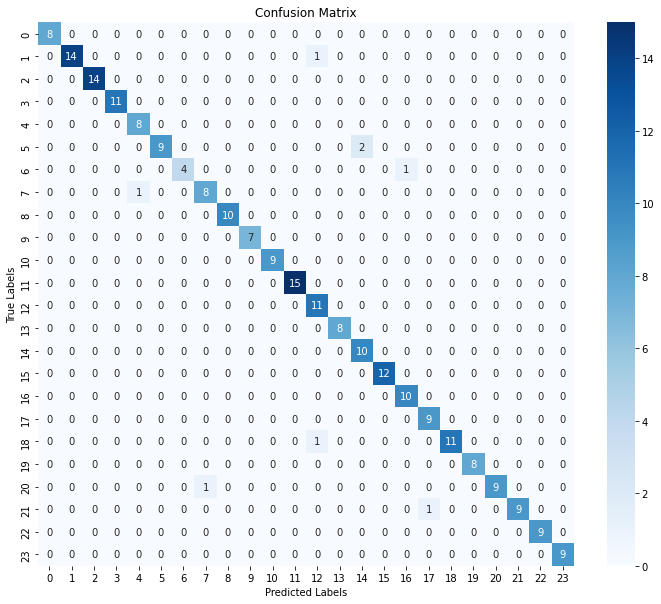

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

cm = confusion_matrix(true_labels, predicted_labels)

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print evaluation measures
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

# Optional: Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
